In [1]:
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
import numpy as np
import time
import pyipopt
import matplotlib.pyplot as plt
from sklearn import preprocessing
import gc

In [2]:
class ML_Model(nn.Module):
    def __init__(self):
        super(ML_Model, self).__init__()
        self.W1 = nn.Linear(4, 12)
        self.W2 = nn.Linear(12, 24)
        self.W3 = nn.Linear(24, 8)
        self.W4 = nn.Linear(8, 2)
        
        self.W5 = nn.Linear(4, 12)
        self.W6 = nn.Linear(12, 24)
        self.W7 = nn.Linear(24, 8)
        self.W8 = nn.Linear(8, 2)
        self.RELU = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x_k, u_k, u_k1):
        h1 = torch.cat((x_k, u_k), axis=2)
        h1 = self.tanh(self.W1(h1))
        h1 = self.tanh(self.W2(h1))
        h1 = self.tanh(self.W3(h1))
        x_k1_pred = self.tanh(self.W4(h1))
        
        h2 = torch.cat((x_k1_pred, u_k1), axis=2)
        h2 = self.tanh(self.W5(h2))
        h2 = self.tanh(self.W6(h2))
        h2 = self.tanh(self.W7(h2))
        x_k2_pred = self.tanh(self.W8(h2))
        
        return x_k1_pred, x_k2_pred

def FNN_next_state(x_k, u_k_u_k1):
    global input_scaler, output_scaler
    input_total_ = input_scaler.transform([[x_k[0], x_k[1], u_k_u_k1[0], u_k_u_k1[1], u_k_u_k1[2], u_k_u_k1[3]]])
    input_total_ = input_total_.reshape(1,1,6)
    
    x_k_ = torch.from_numpy(input_total_[:,:,:2]).to(torch.float32)
    u_k_ = torch.from_numpy(input_total_[:,:,2:4]).to(torch.float32)
    u_k1_ = torch.from_numpy(input_total_[:,:,4:]).to(torch.float32)

    x_k1_, x_k2_ = model(x_k_, u_k_, u_k1_)
    x_k1_ = x_k1_.detach().numpy()[0][0]
    x_k2_ = x_k2_.detach().numpy()[0][0]
    output = output_scaler.inverse_transform([[x_k1_[0], x_k1_[1], x_k2_[0], x_k2_[1]]])[0]
    
    x_k1 = output[:2]
    x_k2 = output[2:]
    
    return np.array(x_k1).reshape(-1,1), np.array(x_k2).reshape(-1,1)

def FP_update_state(x_k, u_k):
    global input_scaler
    x_k1 = np.array([0.0, 0.0])
    
    dx1_dt = F/V*(-x_k[0]+(C_A0s-C_As)+u_k[0])-k_0*np.exp(-Ea/(R*(x_k[1]+T_s)))*(x_k[0]+C_As)**2
    dx2_dt = F/V*(-x_k[1]+(T_0-T_s))+(-drH)/(p_L*Cp)*k_0*np.exp(-Ea/(R*(x_k[1]+T_s)))*(x_k[0]+C_As)**2+(Q_s+u_k[1])/(p_L*Cp*V)

    dt = 0.01
    x_k1[0] = x_k[0] + dx1_dt*dt
    x_k1[1] = x_k[1] + dx2_dt*dt
    
    x_k1_scaled = output_scaler.transform([[x_k1[0], x_k1[1], 0, 0]])[0][:2]
    return x_k1, x_k1_scaled

In [3]:
def get_scaler_profile(file_name):
    sim_data_dict = np.load(f'{file_name}.npy', allow_pickle=True).tolist()
    C_A_input = np.array(sim_data_dict[0])
    T_input = np.array(sim_data_dict[1])
    C_A_output = np.array(sim_data_dict[2])
    T_output = np.array(sim_data_dict[3])
    C_A0_input = np.array(sim_data_dict[4])
    Q_input = np.array(sim_data_dict[5])
    del sim_data_dict
    gc.collect()
    
    # x1_k, x2_k, u1_k, u2_k, u1_k1, u2_k1
    input_k = np.stack((C_A_input, T_input, C_A0_input[:,0], Q_input[:,0], C_A0_input[:,1], Q_input[:,1]), axis=1)
    input_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(input_k)
    
    # x1_k1, x2_k1, x1_k2, x2_k2
    output_k1_k2 = np.stack((C_A_output[:,0], T_output[:,0], C_A_output[:,1], T_output[:,1]), axis=1)
    output_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(output_k1_k2)
    return input_scaler, output_scaler

In [4]:
def eval_f(u_k_u_k1):
    global x_k, Q1, Q2
    assert len(u_k_u_k1) == 4
    x_k1, x_k2 = FNN_next_state(x_k, u_k_u_k1)
    u_k = np.array(u_k_u_k1[:2]).reshape(-1,)
    u_k1 = np.array(u_k_u_k1[2:]).reshape(-1,)
    
    obj_f = x_k2.T@Q1@x_k2 + x_k1.T@Q1@x_k1 + u_k1.T@Q2@u_k1  + u_k.T@Q2@u_k
    return np.array([obj_f])

def eval_grad_f(u_k_u_k1):
    assert len(u_k_u_k1) == 4

    d_u1 = np.array([0.001, 0, 0, 0])
    d_u2 = np.array([0, 25.0, 0, 0])
    d_u1_k1 = np.array([0 ,0, 0.001, 0])
    d_u2_k1 = np.array([0, 0, 0, 25.0])
    d_f_d_u1 = (eval_f(u_k_u_k1+d_u1)-eval_f(u_k_u_k1-d_u1))/(2*d_u1[0])
    d_f_d_u2 = (eval_f(u_k_u_k1+d_u2)-eval_f(u_k_u_k1-d_u2))/(2*d_u2[1])
    d_f_d_u1_k1 = (eval_f(u_k_u_k1+d_u1_k1)-eval_f(u_k_u_k1-d_u1_k1))/(2*d_u1_k1[2])
    d_f_d_u2_k1 = (eval_f(u_k_u_k1+d_u2_k1)-eval_f(u_k_u_k1-d_u2_k1))/(2*d_u2_k1[3])
    return np.array([d_f_d_u1, d_f_d_u2, d_f_d_u1_k1, d_f_d_u2_k1])

In [5]:
def eval_g(u_k_u_k1):
    global x_k, P
    assert len(u_k_u_k1) == 4
    x_k1, _ = FNN_next_state(x_k, u_k_u_k1)
    obj_g = x_k1.T@P@x_k1-x_k.T@P@x_k
    return np.array([obj_g])

def eval_jac_g(u_k_u_k1, flag):
    assert len(u_k_u_k1) == 4
    if flag:
        return (np.array([0, 0]),
                np.array([0, 1]))
    else:
        d_u1 = np.array([0.001, 0, 0, 0])
        d_u2 = np.array([0, 25.0, 0, 0])
        d_g_d_u1 = (eval_g(u_k_u_k1+d_u1)-eval_g(u_k_u_k1-d_u1))/(2*d_u1[0])
        d_g_d_u2 = (eval_g(u_k_u_k1+d_u2)-eval_g(u_k_u_k1-d_u2))/(2*d_u2[1])
        return np.array([d_g_d_u1, d_g_d_u2])

In [6]:
def plot_trace(x_trace_list, u_trace_list, obj_trace_list):
    
    step = [i for i in range(1, len(x_trace_list))]
    x1_list = [x[0] for x in x_trace_list]
    x2_list = [x[1] for x in x_trace_list]
    
    u1_list = [u[0] for u in u_trace_list]
    u2_list = [u[1] for u in u_trace_list]
    
    init_x1 = x_trace_list[0][0]
    init_x2 = x_trace_list[0][1]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2,2,1)
    
    x = np.arange(-2, 2, 0.1)
    y = np.arange(-80, 80, 0.1)
    x, y = np.meshgrid(x,y)
    plt.contour(x, y, 1060*x**2+44*x*y+0.52*y**2, [372], colors=['black']) #stability region

    
    plt.title('x_trajectory')
    plt.plot(x1_list, x2_list, c='r', label='Implicit MPC')
    plt.scatter(x1_list, x2_list, c='r', marker='o', s=15, label='Implicit MPC')
    plt.plot([0], [0], marker='*',markersize=5)
    plt.plot(init_x1, init_x2, marker='s',markersize=5)
    plt.xlim((-2,2))
    plt.ylim((-100,100))
    plt.xlabel('C$_A$-C$_A$$_s$')
    plt.ylabel('T-T$_s$')
    plt.grid()
    plt.legend()

    
    plt.subplot(2,2,2)
    x = np.arange(-2, 2, 0.1)
    y = np.arange(-80, 80, 0.1)
    x, y = np.meshgrid(x,y)
    plt.contour(x, y, 1060*x**2+44*x*y+0.52*y**2, [372], colors=['black']) #stability region
    plt.title('x_trajectory')
    plt.plot(x1_list, x2_list, c='r', label='Implicit MPC')
    plt.scatter(x1_list, x2_list, c='r', marker='o', s=15, label='Implicit MPC')
    plt.plot([0], [0], marker='*',markersize=5)
    plt.plot(init_x1, init_x2, marker='s',markersize=5)
    plt.xlim((-0.1, 0.1))
    plt.ylim((-5,5))
    plt.xlabel('C$_A$-C$_A$$_s$')
    plt.ylabel('T-T$_s$')
    plt.grid()
    plt.legend()
    
    ax1 = plt.subplot(2,2,3)
    ax1.set_title('u_trajectory')
    u1_major_locator = plt.MultipleLocator(1)
    ax1.xaxis.set_major_locator(u1_major_locator)
    line1 = ax1.step(step, u1_list, c='red', linewidth=1, where='post', label='Implicit MPC-u1')
    ax1.axis(ymin=-4.5,ymax=4.5)
    ax1.axhline(0, c='grey', linewidth=0.5)
    ax1.set_ylabel('u1')
    ax1.set_xlabel('step')
    

    ax2 = ax1.twinx()
    line2 = ax2.step(step, u2_list, c='blue', linewidth=1, where='post', label='Implicit MPC-u2')
    ax2.axis(ymin=-5.5e5,ymax=5.5e5)
    ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    ax2.set_ylabel('u2')
    
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    plt.subplot(2,2,4)
    plt.title('obj_trajectory')
    plt.plot(step, obj_trace_list, c='r', label='Implicit MPC')
    plt.xlabel('step')
    plt.ylabel('obj_value')
    # plt.ylim(0, 10000)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    plt.show()

In [7]:
# MPC parameters
Ea = 5.0e4       # Activation energy [kJ/kmol]
R = 8.314    # Gas constant [J/mol/K]
k_0 = 8.46e6    # Arrhenius rate constant [m3/(kmol·hr)]
V = 1.0         # Volume [m3]
p_L = 1000.0   # Density [kg/m3]
Cp = 0.231     # Heat capacity [kJ/(kg·K)]
drH = -1.15e4    # Enthalpy of reaction [kJ/kmol]
F = 5.0        # Flowrate [m3/hr]   
C_As = 1.95    # Unstable steady state output concentration [kmol/m3]
T_s = 402.0      # Unstable steady state feed temperature [K]   
C_A0 = 4         # Inlet feed concentration [kmol/m3]
T_0 = 300       # Inlet feed temperature [K]

model = torch.load('FNN_CSTR_6D_FP.pkl', map_location=torch.device('cpu'))
input_scaler, output_scaler = get_scaler_profile('FP_sim_6D')

In [8]:
# Weights of Objective function
P = np.array([[1060.0, 22.0], 
               [22.0, 0.52]])
Q1 = np.array([[500.0, 0.0],
                [0.0, 0.5]])
Q2 = np.array([[1.0, 0.0],
               [0.0, 8.0e-11]])
C_A0s = 4       # Unstable steady state feed concentration [kmol/m3]
Q_s = 0.0       # Unstable steady state heat removing rate [kJ/hr]
sim_step = 30

# IPOPT parameters
nnzj = 2
nnzh = 2
nvar = 4
ncon = 1
x_L = np.array([-3.5, -5.0e5, -3.5, -5.0e5])
x_U = np.array([3.5, 5.0e5, 3.5, 5.0e5])
g_L = np.array([-1.0e19])
g_U = np.array([-0.0001])

[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
step: 1	status=-3Cannot call restoration phase at point that is almost feasible (violation 0.000000e+00).
Abort in line search due to no other fall back.

[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
step: 2	status=2
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
step: 3	status=-3
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Cannot call restoration phase at point that is almost feasible (violation 0.000000e+00).
Abort in line search due to no other fall back.
step: 4	status=2
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
step: 5	status=-3Cannot call restoration phase at point that is almost feasible (violation 0.000000e+00).
Abort in line search due to no other fall back.

[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
step: 6	status=-3Cannot call restoration phase at p

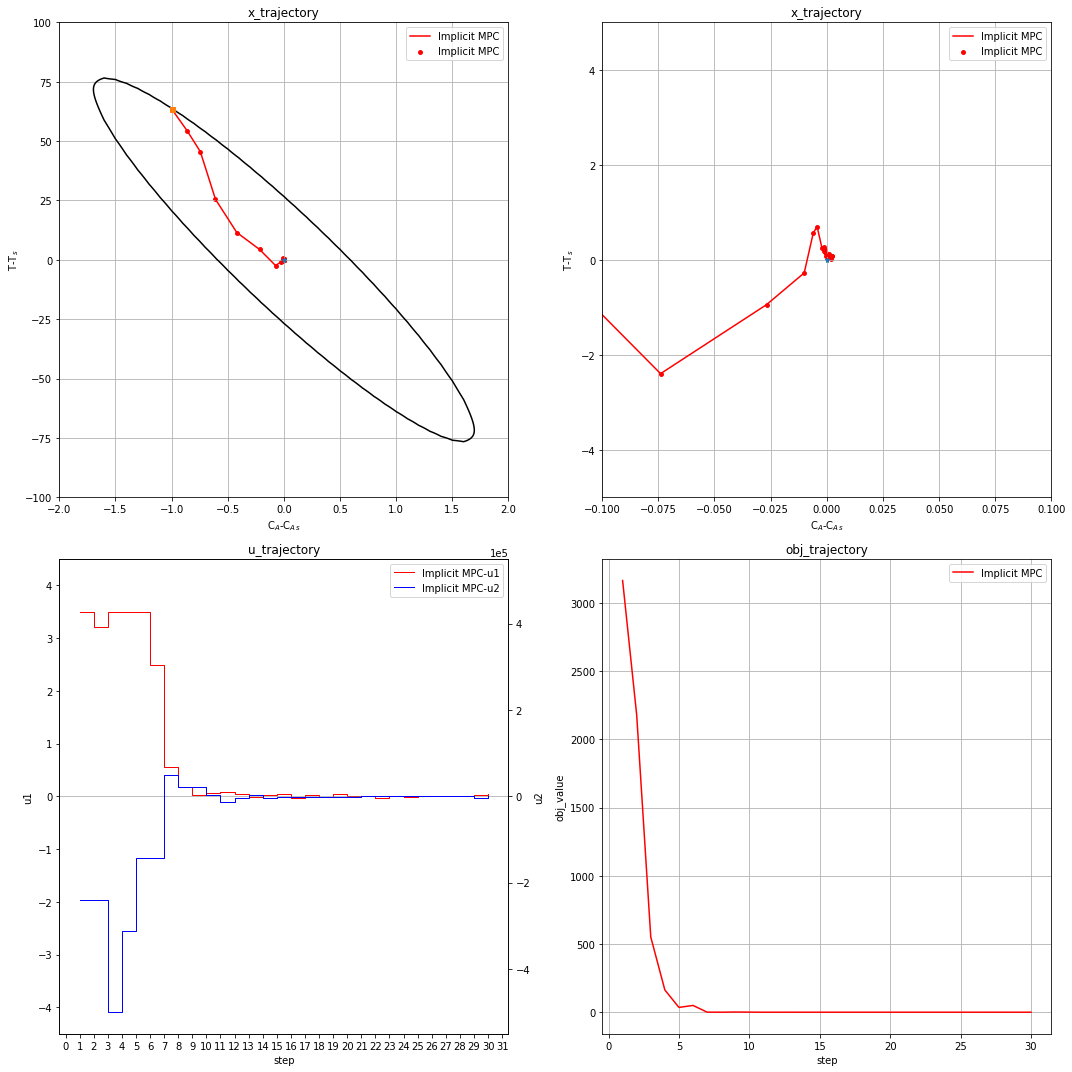

In [11]:
C_A = 1.95 - 1.0
T = 402.0 + 63.6

x_k = np.array([C_A-C_As, T-T_s]) #x1, x2
u_k_u_k1_init = np.array([-3.5, 5.0e5, 0.0, -4.0e4]) #initial u1_k, u2_k, u1_k1, u2_k1 guess 

x_trace_list = [x_k]
x_k_scaled = input_scaler.transform([[x_k[0], x_k[1], 0, 0, 0, 0]])[0][:2]
x_trace_list_scaled = [x_k_scaled]

x_trace_list_fnn = [x_k]
u_trace_list = []
obj_trace_list = []
V_diff_list = []
#simulation
time1 = time.time()
for i in range(sim_step):
    nlp = pyipopt.create(nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g)
    nlp.int_option('max_iter', 10000)
    nlp.num_option('tol', 1e-5)
    nlp.int_option('print_level', 2)
    best_u_k_u_k1, zl, zu, constraint_multipliers, obj, status = nlp.solve(u_k_u_k1_init)
    print (f'step: {i+1}\tstatus={status}')
    
    #x_k1_fnn, x_k2 = FNN_next_state(x_k, best_u_k_u_k1[:2])
    #x_trace_list_fnn.append(x_k1_fnn)
    #V_diff = x_k1_fnn.T@P@x_k1_fnn - x_k.T@P@x_k
    #V_diff_list.append(V_diff)
    
    x_k1, x_k1_scaled = FP_update_state(x_k, best_u_k_u_k1[:2]) # only apply u_k
    x_trace_list_scaled.append(x_k1_scaled)
    x_trace_list.append(x_k1)
    u_trace_list.append(best_u_k_u_k1[:2])
    
    obj_trace_list.append(obj)
    
    u_k_u_k1_init = best_u_k_u_k1
    x_k = x_k1
    nlp.close()
    

time2 = time.time()
print(time2-time1)

x_trace_list = np.array(x_trace_list)
plot_trace(x_trace_list, u_trace_list, obj_trace_list)


In [10]:
save = 0
if save:
    np.save('x_trace2_Im.npy', x_trace_list)
    np.save('x_trace2_scaled_Im.npy', x_trace_list_scaled)
    np.save('u_trace2_Im.npy', u_trace_list)
    np.save('obj_trace2_Im.npy', obj_trace_list)